In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
TRAIN_PATH= '/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Train'
VAL_PATH= '/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Validation'
TEST_PATH= '/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Test'

Libraries

In [ ]:
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import * 
from keras.models import * 
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras import optimizers
from keras.preprocessing import image 
from sklearn.metrics import precision_score,recall_score,classification_report
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_dataset =ImageDataGenerator(rescale=1./255)

checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/FaceMask/Model VGG16/model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


Model Building


In [ ]:
vgg16_model=tf.keras.applications.vgg16.VGG16()
vgg16_model.summary() 

553476096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
INIT_LR = 1e-2
BS = 16
improved_model =tf.keras.models.Sequential()
for layer in vgg16_model.layers[:-1]:
    improved_model.add(layer)
improved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
for layer in improved_model.layers:
    layer.trainable=False
improved_model.add(tf.keras.layers.Dense(2,activation='softmax'))
opt = optimizers.Adam(learning_rate=INIT_LR)
improved_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])
improved_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

Model Training

In [ ]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size = (224,224),
    batch_size = BS,
    class_mode = 'binary')
validation_generator = test_dataset.flow_from_directory(
    VAL_PATH,
    target_size = (224,224),
    batch_size = BS,
    class_mode = 'binary')
hist = improved_model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs =50,
    validation_data = validation_generator,
    validation_steps=2
    ,callbacks=[checkpoint]
    )

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
10/10 [==============================] - 169s 17s/step - loss: 7.2509 - acc: 0.4688 - val_loss: 0.3186 - val_acc: 0.8750
Epoch 2/50
10/10 [==============================] - 97s 10s/step - loss: 0.9741 - acc: 0.7188 - val_loss: 1.1907 - val_acc: 0.5938
Epoch 3/50
10/10 [==============================] - 102s 10s/step - loss: 0.5756 - acc: 0.7750 - val_loss: 0.1558 - val_acc: 0.9375
Epoch 4/50
10/10 [==============================] - 103s 10s/step - loss: 0.5430 - acc: 0.8313 - val_loss: 0.1390 - val_acc: 0.9062
Epoch 5/50
10/10 [==============================] - 97s 10s/step - loss: 0.3877 - acc: 0.8313 - val_loss: 0.6325 - val_acc: 0.8438
Epoch 6/50
10/10 [==============================] - 96s 9s/step - loss: 0.7984 - acc: 0.8250 - val_loss: 0.8000 - val_acc: 0.7188
Epoch 7/50
10/10 [==============================] - 94s 9s/step - loss: 0.6971 - acc: 0.8250 - val_loss: 0.4891 - val_acc: 0.8438
Epoch 8/50
10/10 [==============================] - 94s 9s/step - loss: 0.6550 - a

Save Model

In [ ]:
improved_model.save("/content/gdrive/MyDrive/FaceMask/FM_VGG16_Softmax.h5")


Plotting Training Accuracy





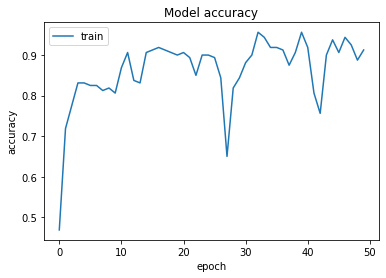

In [ ]:
plt.plot(hist.history['acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.show()

Plotting Validation Accuracy


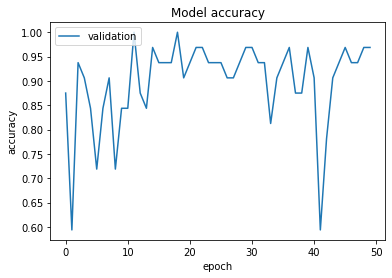

In [ ]:
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation'],loc='upper left')
plt.show()

Getting Results

In [ ]:
train_generator.class_indices

{'WithMask': 0, 'WithoutMask': 1}

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       509
           1       0.98      0.86      0.92       483

    accuracy                           0.93       992
   macro avg       0.93      0.92      0.92       992
weighted avg       0.93      0.93      0.93       992



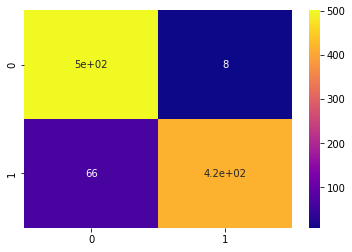

In [ ]:
import os 
y_actual=[]
y_test=[]
for i in os.listdir("/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Test/WithMask"):
  img=image.load_img("/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Test/WithMask/"+i,target_size=(224,224))
  img=image.img_to_array(img)
  img=np.expand_dims(img,axis=0)
  p=(improved_model.predict(img)>0.5).astype("int32")
  y_test.append(p[0,0])
  y_actual.append(1)

for i in os.listdir("/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Test/WithoutMask"):
  img=image.load_img("/content/gdrive/MyDrive/FaceMask/Face Mask Dataset/Test/WithoutMask/"+i,target_size=(224,224))
  img=image.img_to_array(img)
  img=np.expand_dims(img,axis=0)
  p=(improved_model.predict(img)>0.5).astype("int32")
  y_test.append(p[0,0])
  y_actual.append(0)

y_actual=np.array(y_actual)
y_test=np.array(y_test)

from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score
import seaborn as sns

#plotting confusion metrics
cm=confusion_matrix(y_actual,y_test)
from sklearn.metrics import classification_report
sns.heatmap(cm,cmap="plasma",annot=True)

#getting numerical metrics 
print(classification_report(y_actual,y_test))

ROC Curve

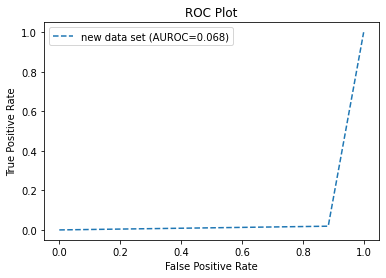

In [ ]:
#plotting ROC curve 
r_auc_new_dataset=roc_auc_score(y_test,y_actual)
r_fpr_new_dataset,r_tpr_new_dataset,_=roc_curve(y_test,y_actual)
plt.plot(r_fpr_new_dataset,r_tpr_new_dataset,linestyle='--',label='new data set (AUROC=%0.3f)' %r_auc_new_dataset)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
#infite loop to avoid collab runtime from shuttingdown after training
while True:pass